# Новый раздел

In [ ]:
!kaggle datasets download -d shubhamgoel27/dermnet

In [ ]:
!unzip dermnet.zip  -d dermnet


In [ ]:
!ls dermnet/train

'Acne and Rosacea Photos'
'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
'Atopic Dermatitis Photos'
'Bullous Disease Photos'
'Cellulitis Impetigo and other Bacterial Infections'
'Eczema Photos'
'Exanthems and Drug Eruptions'
'Hair Loss Photos Alopecia and other Hair Diseases'
'Herpes HPV and other STDs Photos'
'Light Diseases and Disorders of Pigmentation'
'Lupus and other Connective Tissue diseases'
'Melanoma Skin Cancer Nevi and Moles'
'Nail Fungus and other Nail Disease'
'Poison Ivy Photos and other Contact Dermatitis'
'Psoriasis pictures Lichen Planus and related diseases'
'Scabies Lyme Disease and other Infestations and Bites'
'Seborrheic Keratoses and other Benign Tumors'
'Systemic Disease'
'Tinea Ringworm Candidiasis and other Fungal Infections'
'Urticaria Hives'
'Vascular Tumors'
'Vasculitis Photos'
'Warts Molluscum and other Viral Infections'


In [ ]:
pip install timm

In [ ]:

import timm
import os
import pandas as pd

DIR = "dermnet/"
DIR_TRAIN = "dermnet/train/"
DIR_TEST = "dermnet/test/"

In [ ]:
### Exploring Dataset
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    #print(f'Class {_class}: train amount {train_count}, test amount {test_count} ')
    class_dict.update({'Class': _class, 'Train': len(os.listdir(DIR_TRAIN + _class)), 'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print("Total train images: ",train_count)
print("Total test images: ",test_count)
print(pd.DataFrame(classes_df))

Total Classes:  23
Total train images:  15557
Total test images:  4002
                                                Class  Train  Test
0                             Acne and Rosacea Photos    840   312
1   Actinic Keratosis Basal Cell Carcinoma and oth...   1149   288
2                            Atopic Dermatitis Photos    489   123
3                              Bullous Disease Photos    448   113
4   Cellulitis Impetigo and other Bacterial Infect...    288    73
5                                       Eczema Photos   1235   309
6                        Exanthems and Drug Eruptions    404   101
7   Hair Loss Photos Alopecia and other Hair Diseases    239    60
8                    Herpes HPV and other STDs Photos    405   102
9        Light Diseases and Disorders of Pigmentation    568   143
10         Lupus and other Connective Tissue diseases    420   105
11                Melanoma Skin Cancer Nevi and Moles    463   116
12                 Nail Fungus and other Nail Disease   10

## DINO (output vector 512)

In [ ]:
import argparse
import datetime
import time
import math
import json
from pathlib import Path

import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
from vision_transformer import DINOHead
from torchvision import transforms as pth_transforms


import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torchvision_archs = sorted(name for name in torchvision_models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(torchvision_models.__dict__[name]))

def get_args_parser():
    parser = argparse.ArgumentParser('DINO', add_help=False)

    # Model parameters
    parser.add_argument('--arch', default='vit_small', type=str,
        choices=['vit_tiny', 'vit_small', 'vit_base', 'xcit', 'deit_tiny', 'deit_small'] \
                + torchvision_archs + torch.hub.list("facebookresearch/xcit"),
        help="""Name of architecture to train. For quick experiments with ViTs,
        we recommend using vit_tiny or vit_small.""")
    parser.add_argument('--patch_size', default=16, type=int, help="""Size in pixels
        of input square patches - default 16 (for 16x16 patches). Using smaller
        values leads to better performance but requires more memory. Applies only
        for ViTs (vit_tiny, vit_small and vit_base). If <16, we recommend disabling
        mixed precision training (--use_fp16 false) to avoid unstabilities.""")
    parser.add_argument('--out_dim', default=512, type=int, help="""Dimensionality of                                # the vector length is 512
        the DINO head output. For complex and large datasets large values (like 65k) work well.""")
    parser.add_argument('--norm_last_layer', default=True, type=utils.bool_flag,
        help="""Whether or not to weight normalize the last layer of the DINO head.
        Not normalizing leads to better performance but can make the training unstable.
        In our experiments, we typically set this paramater to False with vit_small and True with vit_base.""")
    parser.add_argument('--momentum_teacher', default=0.996, type=float, help="""Base EMA
        parameter for teacher update. The value is increased to 1 during training with cosine schedule.
        We recommend setting a higher value with small batches: for example use 0.9995 with batch size of 256.""")
    parser.add_argument('--use_bn_in_head', default=False, type=utils.bool_flag,
        help="Whether to use batch normalizations in projection head (Default: False)")

    # Temperature teacher parameters
    parser.add_argument('--warmup_teacher_temp', default=0.04, type=float,
        help="""Initial value for the teacher temperature: 0.04 works well in most cases.
        Try decreasing it if the training loss does not decrease.""")
    parser.add_argument('--teacher_temp', default=0.04, type=float, help="""Final value (after linear warmup)
        of the teacher temperature. For most experiments, anything above 0.07 is unstable. We recommend
        starting with the default value of 0.04 and increase this slightly if needed.""")
    parser.add_argument('--warmup_teacher_temp_epochs', default=0, type=int,
        help='Number of warmup epochs for the teacher temperature (Default: 30).')

    # Training/Optimization parameters
    parser.add_argument('--use_fp16', type=utils.bool_flag, default=True, help="""Whether or not
        to use half precision for training. Improves training time and memory requirements,
        but can provoke instability and slight decay of performance. We recommend disabling
        mixed precision if the loss is unstable, if reducing the patch size or if training with bigger ViTs.""")
    parser.add_argument('--weight_decay', type=float, default=0.04, help="""Initial value of the
        weight decay. With ViT, a smaller value at the beginning of training works well.""")
    parser.add_argument('--weight_decay_end', type=float, default=0.4, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")
    parser.add_argument('--clip_grad', type=float, default=3.0, help="""Maximal parameter
        gradient norm if using gradient clipping. Clipping with norm .3 ~ 1.0 can
        help optimization for larger ViT architectures. 0 for disabling.""")
    parser.add_argument('--batch_size_per_gpu', default=32, type=int,           # batch size = 32
        help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--epochs', default=100, type=int, help='Number of epochs of training.')
    parser.add_argument('--freeze_last_layer', default=1, type=int, help="""Number of epochs
        during which we keep the output layer fixed. Typically doing so during
        the first epoch helps training. Try increasing this value if the loss does not decrease.""")
    parser.add_argument("--lr", default=0.0005, type=float, help="""Learning rate at the end of
        linear warmup (highest LR used during training). The learning rate is linearly scaled
        with the batch size, and specified here for a reference batch size of 256.""")
    parser.add_argument("--warmup_epochs", default=10, type=int,
        help="Number of epochs for the linear learning-rate warm up.")
    parser.add_argument('--min_lr', type=float, default=1e-6, help="""Target LR at the
        end of optimization. We use a cosine LR schedule with linear warmup.""")
    parser.add_argument('--optimizer', default='adamw', type=str,
        choices=['adamw', 'sgd', 'lars'], help="""Type of optimizer. We recommend using adamw with ViTs.""")
    parser.add_argument('--drop_path_rate', type=float, default=0.1, help="stochastic depth rate")
    parser.add_argument('-f')

    # Multi-crop parameters
    parser.add_argument('--global_crops_scale', type=float, nargs='+', default=(0.4, 1.),
        help="""Scale range of the cropped image before resizing, relatively to the origin image.
        Used for large global view cropping. When disabling multi-crop (--local_crops_number 0), we
        recommand using a wider range of scale ("--global_crops_scale 0.14 1." for example)""")
    parser.add_argument('--local_crops_number', type=int, default=8, help="""Number of small
        local views to generate. Set this parameter to 0 to disable multi-crop training.
        When disabling multi-crop we recommend to use "--global_crops_scale 0.14 1." """)
    parser.add_argument('--local_crops_scale', type=float, nargs='+', default=(0.05, 0.4),
        help="""Scale range of the cropped image before resizing, relatively to the origin image.
        Used for small local view cropping of multi-crop.""")

    # Misc
    parser.add_argument('--data_path', default=DIR_TRAIN, type=str,
        help='Please specify path to the training data.')
    parser.add_argument('--output_dir', default="512.", type=str, help='Path to save logs and checkpoints.')
    parser.add_argument('--saveckp_freq', default=20, type=int, help='Save checkpoint every x epochs.')
    parser.add_argument('--seed', default=0, type=int, help='Random seed.')
    parser.add_argument('--num_workers', default=4, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up
        distributed training; see https://pytorch.org/docs/stable/distributed.html""")
    parser.add_argument("--local_rank", default=0, type=int, help="Please ignore and do not set this argument.")
    return parser


def train_dino(args):
    utils.init_distributed_mode(args)
    utils.fix_random_seeds(args.seed)
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    transform = DataAugmentationDINO(
        args.global_crops_scale,
        args.local_crops_scale,
        args.local_crops_number,
    )
    dataset = datasets.ImageFolder(args.data_path, transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    print(f"Data loaded: there are {len(dataset)} images.")

    # ============ building student and teacher networks ... ============
    # we changed the name DeiT-S for ViT-S to avoid confusions
    args.arch = args.arch.replace("deit", "vit")
    # if the network is a Vision Transformer (i.e. vit_tiny, vit_small, vit_base)
    if args.arch in vits.__dict__.keys():
        student = vits.__dict__[args.arch](
            patch_size=args.patch_size,
            drop_path_rate=args.drop_path_rate,  # stochastic depth
        )
        teacher = vits.__dict__[args.arch](patch_size=args.patch_size)
        embed_dim = student.embed_dim
    # if the network is a XCiT
    elif args.arch in torch.hub.list("facebookresearch/xcit"):
        student = torch.hub.load('facebookresearch/xcit', args.arch,
                                 pretrained=False, drop_path_rate=args.drop_path_rate)
        teacher = torch.hub.load('facebookresearch/xcit', args.arch, pretrained=False)
        embed_dim = student.embed_dim
    # otherwise, we check if the architecture is in torchvision models
    elif args.arch in torchvision_models.__dict__.keys():
        student = torchvision_models.__dict__[args.arch]()
        teacher = torchvision_models.__dict__[args.arch]()
        embed_dim = student.fc.weight.shape[1]
    else:
        print(f"Unknow architecture: {args.arch}")

    # multi-crop wrapper handles forward with inputs of different resolutions
    student = utils.MultiCropWrapper(student, DINOHead(
        embed_dim,
        args.out_dim,
        use_bn=args.use_bn_in_head,
        norm_last_layer=args.norm_last_layer,
    ))
    teacher = utils.MultiCropWrapper(
        teacher,
        DINOHead(embed_dim, args.out_dim, args.use_bn_in_head),
    )
    # move networks to gpu
    student, teacher = student.cuda(), teacher.cuda()
    # synchronize batch norms (if any)
    if utils.has_batchnorms(student):
        student = nn.SyncBatchNorm.convert_sync_batchnorm(student)
        teacher = nn.SyncBatchNorm.convert_sync_batchnorm(teacher)

        # we need DDP wrapper to have synchro batch norms working...
        teacher = nn.parallel.DistributedDataParallel(teacher, device_ids=[args.gpu])
        teacher_without_ddp = teacher.module
    else:
        # teacher_without_ddp and teacher are the same thing
        teacher_without_ddp = teacher
    student = nn.parallel.DistributedDataParallel(student, device_ids=[args.gpu])
    # teacher and student start with the same weights
    teacher_without_ddp.load_state_dict(student.module.state_dict())
    # there is no backpropagation through the teacher, so no need for gradients
    for p in teacher.parameters():
        p.requires_grad = False
    print(f"Student and Teacher are built: they are both {args.arch} network.")

    # ============ preparing loss ... ============
    dino_loss = DINOLoss(
        args.out_dim,
        args.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        args.warmup_teacher_temp,
        args.teacher_temp,
        args.warmup_teacher_temp_epochs,
        args.epochs,
    ).cuda()

    # ============ preparing optimizer ... ============
    params_groups = utils.get_params_groups(student)
    if args.optimizer == "adamw":
        optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs
    elif args.optimizer == "sgd":
        optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
    elif args.optimizer == "lars":
        optimizer = utils.LARS(params_groups)  # to use with convnet and large batches
    # for mixed precision training
    fp16_scaler = None
    if args.use_fp16:
        fp16_scaler = torch.cuda.amp.GradScaler()

    # ============ init schedulers ... ============
    lr_schedule = utils.cosine_scheduler(
        args.lr * (args.batch_size_per_gpu * utils.get_world_size()) / 256.,  # linear scaling rule
        args.min_lr,
        args.epochs, len(data_loader),
        warmup_epochs=args.warmup_epochs,
    )
    wd_schedule = utils.cosine_scheduler(
        args.weight_decay,
        args.weight_decay_end,
        args.epochs, len(data_loader),
    )
    # momentum parameter is increased to 1. during training with a cosine schedule
    momentum_schedule = utils.cosine_scheduler(args.momentum_teacher, 1,
                                               args.epochs, len(data_loader))
    print(f"Loss, optimizer and schedulers ready.")

    # ============ optionally resume training ... ============
    to_restore = {"epoch": 0}
    utils.restart_from_checkpoint(
        os.path.join(args.output_dir, "checkpoint.pth"),
        run_variables=to_restore,
        student=student,
        teacher=teacher,
        optimizer=optimizer,
        fp16_scaler=fp16_scaler,
        dino_loss=dino_loss,
    )
    start_epoch = to_restore["epoch"]

    start_time = time.time()
    print("Starting DINO training !")
    for epoch in range(start_epoch, args.epochs):
        data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(student, teacher, teacher_without_ddp, dino_loss,
            data_loader, optimizer, lr_schedule, wd_schedule, momentum_schedule,
            epoch, fp16_scaler, args)

        # ============ writing logs ... ============
        save_dict = {
            'student': student.state_dict(),
            'teacher': teacher.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': args,
            'dino_loss': dino_loss.state_dict(),
        }
        if fp16_scaler is not None:
            save_dict['fp16_scaler'] = fp16_scaler.state_dict()
        utils.save_on_master(save_dict, os.path.join(args.output_dir, 'checkpoint.pth'))
        if args.saveckp_freq and epoch % args.saveckp_freq == 0:
            utils.save_on_master(save_dict, os.path.join(args.output_dir, f'checkpoint{epoch:04}.pth'))
        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     'epoch': epoch}
        if utils.is_main_process():
            with (Path(args.output_dir) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


def train_one_epoch(student, teacher, teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr_schedule, wd_schedule, momentum_schedule,epoch,
                    fp16_scaler, args):
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Epoch: [{}/{}]'.format(epoch, args.epochs)
    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            sys.exit(1)

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args.clip_grad:
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args.clip_grad:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student,
                                              args.freeze_last_layer)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher_without_ddp.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        dist.all_reduce(batch_center)
        batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)


class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops


## Train DINO

In [ ]:
parser = argparse.ArgumentParser('DINO', parents=[get_args_parser()])
args = parser.parse_args()
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
train_dino(args)

## DINO+Knn Classification

In [ ]:
def extract_feature_pipeline(args):
    # ============ preparing data ... ============
    transform = pth_transforms.Compose([
        pth_transforms.Resize(256, interpolation=3),
        pth_transforms.CenterCrop(224),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    dataset_train = ReturnIndexDataset(os.path.join(args.data_path, "train"), transform=transform)
    dataset_val = ReturnIndexDataset(os.path.join(args.data_path, "test"), transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset_train, shuffle=False)
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    print(f"Data loaded with {len(dataset_train)} train and {len(dataset_val)} val imgs.")

    # ============ building network ... ============
    if "vit" in args.arch:
        model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
        print(f"Model {args.arch} {args.patch_size}x{args.patch_size} built.")
    elif "xcit" in args.arch:
        model = torch.hub.load('facebookresearch/xcit', args.arch, num_classes=0)
    elif args.arch in torchvision_models.__dict__.keys():
        model = torchvision_models.__dict__[args.arch](num_classes=0)
    else:
        print(f"Architecture {args.arch} non supported")
        sys.exit(1)
    model.cuda()
    utils.load_pretrained_weights(model, args.pretrained_weights, args.checkpoint_key, args.arch, args.patch_size)
    model.eval()

    # ============ extract features ... ============
    print("Extracting features for train set...")
    train_features = extract_features(model, data_loader_train, args.use_cuda)
    print("Extracting features for val set...")
    test_features = extract_features(model, data_loader_val, args.use_cuda)

    if utils.get_rank() == 0:
        train_features = nn.functional.normalize(train_features, dim=1, p=2)
        test_features = nn.functional.normalize(test_features, dim=1, p=2)

    train_labels = torch.tensor([s[-1] for s in dataset_train.samples]).long()
    test_labels = torch.tensor([s[-1] for s in dataset_val.samples]).long()
    # save features and labels
    if args.dump_features and dist.get_rank() == 0:
        torch.save(train_features.cpu(), os.path.join(args.dump_features, "trainfeat.pth"))
        torch.save(test_features.cpu(), os.path.join(args.dump_features, "testfeat.pth"))
        torch.save(train_labels.cpu(), os.path.join(args.dump_features, "trainlabels.pth"))
        torch.save(test_labels.cpu(), os.path.join(args.dump_features, "testlabels.pth"))
    return train_features, test_features, train_labels, test_labels


@torch.no_grad()
def extract_features(model, data_loader, use_cuda=True, multiscale=False):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    for samples, index in metric_logger.log_every(data_loader, 10):
        samples = samples.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)
        if multiscale:
            feats = utils.multi_scale(samples, model)
        else:
            feats = model(samples).clone()

        # init storage feature matrix
        if dist.get_rank() == 0 and features is None:
            features = torch.zeros(len(data_loader.dataset), feats.shape[-1])
            if use_cuda:
                features = features.cuda(non_blocking=True)
            print(f"Storing features into tensor of shape {features.shape}")

        # get indexes from all processes
        y_all = torch.empty(dist.get_world_size(), index.size(0), dtype=index.dtype, device=index.device)
        y_l = list(y_all.unbind(0))
        y_all_reduce = torch.distributed.all_gather(y_l, index, async_op=True)
        y_all_reduce.wait()
        index_all = torch.cat(y_l)

        # share features between processes
        feats_all = torch.empty(
            dist.get_world_size(),
            feats.size(0),
            feats.size(1),
            dtype=feats.dtype,
            device=feats.device,
        )
        output_l = list(feats_all.unbind(0))
        output_all_reduce = torch.distributed.all_gather(output_l, feats, async_op=True)
        output_all_reduce.wait()

        # update storage feature matrix
        if dist.get_rank() == 0:
            if use_cuda:
                features.index_copy_(0, index_all, torch.cat(output_l))
            else:
                features.index_copy_(0, index_all.cpu(), torch.cat(output_l).cpu())
    return features


@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=23):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).cuda()
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5


class ReturnIndexDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, idx

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser('Evaluation with weighted k-NN')
    parser.add_argument('--batch_size_per_gpu', default=128, type=int, help='Per-GPU batch-size')
    parser.add_argument('--nb_knn', default=[10, 20, 100, 200], nargs='+', type=int,
        help='Number of NN to use. 20 is usually working the best.')
    parser.add_argument('--temperature', default=0.07, type=float,
        help='Temperature used in the voting coefficient')
    parser.add_argument('--pretrained_weights', default='512./checkpoint.pth', type=str, help="Path to pretrained weights to evaluate.")
    parser.add_argument('--use_cuda', default=True, type=utils.bool_flag,
        help="Should we store the features on GPU? We recommend setting this to False if you encounter OOM")
    parser.add_argument('--arch', default='vit_small', type=str, help='Architecture')
    parser.add_argument('--patch_size', default=16, type=int, help='Patch resolution of the model.')
    parser.add_argument("--checkpoint_key", default="teacher", type=str,
        help='Key to use in the checkpoint (example: "teacher")')
    parser.add_argument('--dump_features', default=None,
        help='Path where to save computed features, empty for no saving')
    parser.add_argument('--load_features', default=None, help="""If the features have
        already been computed, where to find them.""")
    parser.add_argument('--num_workers', default=4, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up
        distributed training; see https://pytorch.org/docs/stable/distributed.html""")
    parser.add_argument("--local_rank", default=0, type=int, help="Please ignore and do not set this argument.")
    parser.add_argument('--data_path', default=DIR, type=str)
    args, unknown = parser.parse_known_args()         

    utils.init_distributed_mode(args)
    print("git:\n  {}\n".format(utils.get_sha()))
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    if args.load_features:
        train_features = torch.load(os.path.join(args.load_features, "trainfeat.pth"))
        test_features = torch.load(os.path.join(args.load_features, "testfeat.pth"))
        train_labels = torch.load(os.path.join(args.load_features, "trainlabels.pth"))
        test_labels = torch.load(os.path.join(args.load_features, "testlabels.pth"))
    else:
        # need to extract features !
        train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

    if utils.get_rank() == 0:
        if args.use_cuda:
            train_features = train_features.cuda()
            test_features = test_features.cuda()
            train_labels = train_labels.cuda()
            test_labels = test_labels.cuda()

        print("Features are ready!\nStart the k-NN classification.")
        for k in args.nb_knn:
            top1, top5 = knn_classifier(train_features, train_labels,
                test_features, test_labels, k, args.temperature)
            print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
    dist.barrier()

## DINO vizualize attention

In [ ]:
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from torchvision import transforms as pth_transforms
from PIL import Image

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [ ]:
parser = argparse.ArgumentParser('Visualize Self-Attention maps')
parser.add_argument('--arch', default='vit_small', type=str,
    choices=['vit_tiny', 'vit_small', 'vit_base'], help='Architecture (support only ViT atm).')
parser.add_argument('--patch_size', default=8, type=int, help='Patch resolution of the model.')
parser.add_argument('--pretrained_weights', default='512./checkpoint.pth', type=str,
    help="Path to pretrained weights to load.")
parser.add_argument("--checkpoint_key", default="teacher", type=str,
    help='Key to use in the checkpoint (example: "teacher")')
parser.add_argument("--image_path", default='test/Eczema Photos/stasis-dermatitis-85.jpg', type=str, help="Path of the image to load.")
parser.add_argument("--image_size", default=(480, 480), type=int, nargs="+", help="Resize image.")
parser.add_argument('--output_dir', default='32.', help='Path where to save visualizations.')
parser.add_argument("--threshold", type=float, default=0.6, help="""We visualize masks
    obtained by thresholding the self-attention maps to keep xx% of the mass.""")
args, unknown = parser.parse_known_args()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


32./attn-head0.png saved.
32./attn-head1.png saved.
32./attn-head2.png saved.
32./attn-head3.png saved.
32./attn-head4.png saved.
32./attn-head5.png saved.
32./mask_th0.6_head0.png saved.
32./mask_th0.6_head1.png saved.
32./mask_th0.6_head2.png saved.
32./mask_th0.6_head3.png saved.
32./mask_th0.6_head4.png saved.
32./mask_th0.6_head5.png saved.


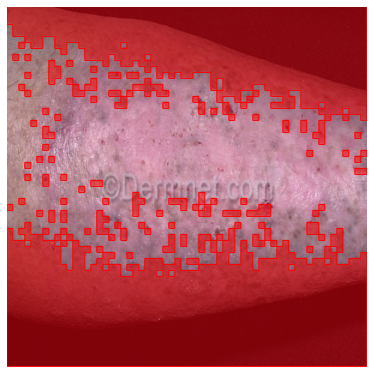

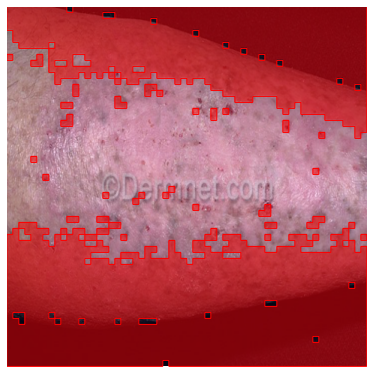

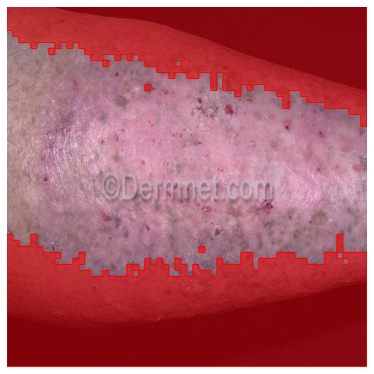

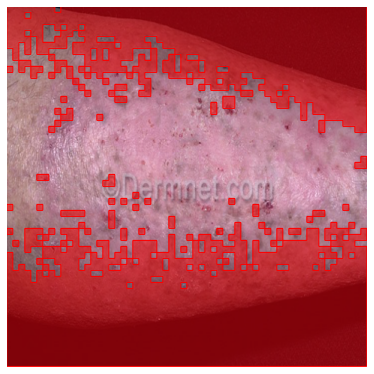

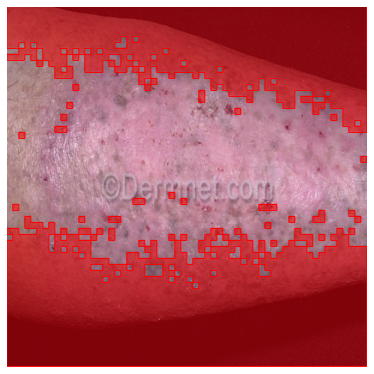

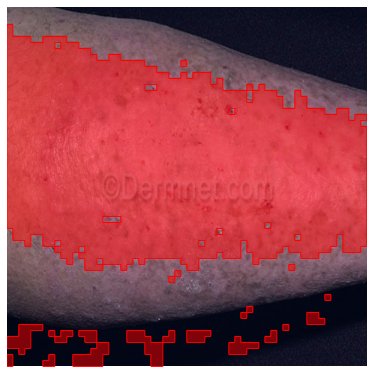

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=23)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)

# open image
if args.image_path is None:
    # user has not specified any image - we use our own image
    print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
    print("Since no image path have been provided, we take the first image in our paper.")
    response = requests.get("test/Eczema Photos/stasis-dermatitis-85.jpg")
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
elif os.path.isfile(args.image_path):
    with open(args.image_path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
else:
    print(f"Provided image path {args.image_path} is non valid.")
    sys.exit(1)
transform = pth_transforms.Compose([
    pth_transforms.Resize(args.image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // args.patch_size
h_featmap = img.shape[-1] // args.patch_size

attentions = model.get_last_selfattention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

if args.threshold is not None:
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - args.threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0].cpu().numpy()

# save attentions heatmaps
os.makedirs(args.output_dir, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args.output_dir, "img.png"))
for j in range(nh):
    fname = os.path.join(args.output_dir, "attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

if args.threshold is not None:
    image = skimage.io.imread(os.path.join(args.output_dir, "img.png"))
    for j in range(nh):
        display_instances(image, th_attn[j], fname=os.path.join(args.output_dir, "mask_th" + str(args.threshold) + "_head" + str(j) +".png"), blur=False)